In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from tqdm.notebook import tqdm
import lightgbm as lgb

%matplotlib inline

## Implementation FRUFS(Feature Relevance based Unsupervised Feature Selection)  
Article: https://www.deepwizai.com/projects/how-to-perform-unsupervised-feature-selection-using-supervised-algorithms  

**重み行列について**  
- 行: i番目の特徴量を表すために他の特徴量にかける重み．  
- 列: i列目以外の特徴量を表すためにi番目の特徴量にかける重み．  

In [3]:
class FRUFS:
    def __init__(self, df: pd.DataFrame, method: str = "linear"):
        self.df = df
        self.W = np.zeros((self.df.shape[1], self.df.shape[1]))
        self.W_average = np.zeros(self.df.shape[1])
        self.method = method

        if self.method == "linear":
            self.model_func = LinearRegression
        elif self.method == "lgb":
            self.model_func = lgb.LGBMRegressor
        else:
            raise NameError("'method' variable is 'linear' or 'lgb'")

    # 他の特徴量を計算するための重み/重要度を計算する
    def calc_coef(self):
        X = self.df.values
        for i in tqdm(range(X.shape[1]), total=X.shape[1],
                      desc="calculate coefficient/importances"):
            # 重み/重要度を格納するインデックスの指定
            indices = np.concatenate((np.arange(i).reshape(-1, 1),
                                      np.arange(i+1, X.shape[1]).reshape(-1, 1)))

            train_X = np.hstack((X[:, :i], X[:, i+1:]))  # i番目の特徴量を外す
            train_y = X[:, i]  # i番目の特徴量

            # i番目の特徴量を他の特徴量で表現するための学習
            model = self.model_func()
            model.fit(train_X, train_y)

            # モデルの重み/重要度をWに格納する
            if self.method == "linear":
                coef = model.coef_
                coef = np.absolute(coef)
            elif self.method == "lgb":
                coef = model.feature_importances_

            self.W[i, indices] = coef.reshape(-1, 1)

        # 各特徴量が他の特徴量を表すときの重み/重要度の平均を計算
        self.W_average = self.W.mean(axis=0)
        self.average_coef_df = pd.DataFrame({"columns": self.df.columns.values,
                                             "importances": self.W_average})

    # 各特徴量の重要度が高い順にプロット
    def plot_coef(self):
        if not hasattr(self, "average_coef_df"):
            raise Exception("Please Execute 'calc_coef' function before")

        # 重要度でデータをソートする
        average_coef_df = self.average_coef_df.sort_values("importances")

        # 棒グラフとして描画
        plt.figure(figsize=(20, 10))
        plt.barh(average_coef_df["columns"], average_coef_df["importances"])
        plt.title("Feature Importances Plot")
        plt.grid(True)
        plt.show()

    # 重要度のデータを取得する関数
    def get_coef(self, average: bool = False):
        if average:
            return self.average_coef_df
        else:
            return self.W

In [4]:
method = "lgb"

# A utility variable to define the number of classes
num_classes = 10
# A utility variable that defines the number of sub-samples to pick from each class
subset_samples = 500

# MNIST library allows easy loading of MNIST data
X, y = fetch_openml("mnist_784", version=1, return_X_y=True)
X_train, Y_train = X[:60000], y[:60000]
X_test, Y_test = X[60000:], y[60000:]

# Converting to numpy matrix
X_train, Y_train = np.asarray(X_train).astype(int), np.asarray(Y_train).astype(int)
X_test, Y_test = np.asarray(X_test).astype(int), np.asarray(Y_test).astype(int)

# Take a stratified random subset of samples from each class
inds = list()
for i in range(num_classes):
    curr_inds = np.where(Y_train == i)[0]
    inds += list(curr_inds[np.random.randint(0, len(curr_inds), size=subset_samples)])

# Use the indices generated above to take a subset of the training data
X_train = X_train[inds]
Y_train = Y_train[inds]

# Take a stratified random subset of samples from each class
inds = list()
for i in range(num_classes):
    curr_inds = np.where(Y_test == i)[0]
    inds += list(curr_inds[np.random.randint(0, len(curr_inds), size=subset_samples)])

# Use the indices generated above to take a subset of the test data
X_test = X_test[inds]
Y_test = Y_test[inds]

# Check out the data shapes
print("Train Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)

Train Data Shape: (5000, 784)
Test Data Shape: (5000, 784)


In [5]:
# We are going to use the K-Means algorithm
model_kmeans = KMeans(n_clusters=num_classes, random_state=27)
model_kmeans.fit(X_train)
preds = model_kmeans.predict(X_test)

# We are going to use the NMI metric to measure the quality/performance of the clustering 
baseline_score = normalized_mutual_info_score(Y_test, preds)
print("Baseline NMI Score:", baseline_score)

Baseline NMI Score: 0.4973729379536027


In [6]:
X_train_df = pd.DataFrame(X_train, columns=[i+1 for i in range(784)])
mnist_FRUFS = FRUFS(X_train_df, method=method)
mnist_FRUFS.calc_coef()
coef_df = mnist_FRUFS.get_coef(average=True)
display(coef_df.head())

calculate coefficient/importances:   0%|          | 0/784 [00:00<?, ?it/s]

,columns,importances
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [7]:
feat_imps = coef_df["importances"].values

# We will use this variable to save NMI scores
scores_nmi, max_score = list(), 0
# This variable is to evaluate the quality of clustering
t_entropy = list()
# Number of features to consider at a time
feats_wind = 20
# Sort the features according to their importance score in descending order
inds = np.argsort(np.absolute(feat_imps))[::-1]

for i in tqdm(range(feats_wind, X_train.shape[1], feats_wind)):
    x_train, x_test = X_train[:, inds[:i]], X_test[:, inds[:i]]
#     x_test_d = X_test_d[:,inds[:i]]
    # Run K-Means for current set of top features
    model_kmeans = KMeans(n_clusters=num_classes, random_state=27)
    model_kmeans.fit(x_train)
    preds = model_kmeans.predict(x_test)
    # Save the scores
    scores_nmi.append(normalized_mutual_info_score(Y_test, preds))

    # Save the maximum Score and corresponding number of features
    if scores_nmi[-1] > max_score:
        max_score = scores_nmi[-1]
        max_feats = i

print("Feature Selection NMI Score:", max_score, "\t Number of features used:", max_feats)

  0%|          | 0/39 [00:00<?, ?it/s]

Feature Selection NMI Score: 0.5335092351371437 	 Number of features used: 320


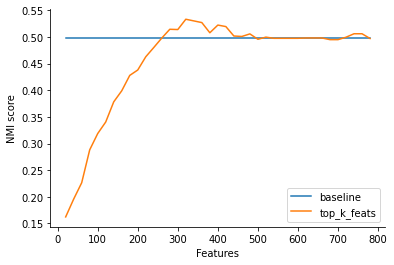

In [8]:
# Plot out the baseline score and all scores due to addition of top features
sns.lineplot(x=np.arange(feats_wind, X_train.shape[1], feats_wind), y=[baseline_score for i in range(feats_wind, X_train.shape[1], feats_wind)], label="baseline")
sns.lineplot(x=np.arange(feats_wind, X_train.shape[1], feats_wind), y=scores_nmi, label="top_k_feats")
sns.despine()
plt.xlabel("Features")
plt.ylabel("NMI score")

plt.savefig(f"{method}_score.png")
plt.show()